In [555]:
import numpy as np
import matplotlib.pyplot as plt

In [556]:
T = 10
n = 10
alpha = 0.9
beta = 0.2
gamma = 0.1
Lambda = [1,5]
cpd_z = [1-alpha,alpha,0.5]
Gamma = np.array(
    [
        [1-gamma,0,gamma],
        [0,1-gamma,gamma],
        [beta/2,beta/2,1-beta]
    ]
)



In [557]:
# Since numpy doesn't have built in support for categorical distribution
def categorical(distribution: np.array):
    # returns the result of a single sample drawn from a binomial distribution <distribution> 
    sample = np.random.multinomial(1,distribution)
    res = np.where(sample)[0][0]
    return res

In [558]:
# Simulate

C = np.zeros(T,dtype='int32')
Z = np.zeros((T,n),dtype='int32')
X = np.zeros((T,n),dtype='int32')
C[0] = 2
for t in range(T):
    if t == 0:
        pass
    else:
        C[t] = categorical(Gamma[C[t-1]])
    Z[t] = np.random.binomial(1,cpd_z[C[t]],size=n)
    for i in range(n):
        X[t][i] = np.random.poisson(Lambda[Z[t][i]])

    


Text(0.5, 0, 't')

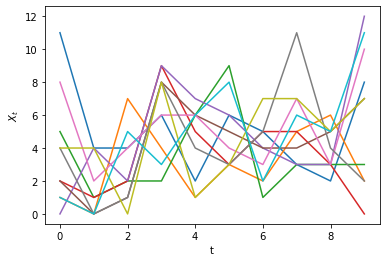

In [559]:
for i in range(n):
    plt.plot(X[0:,i])
plt.ylabel(r'$X_{t}$')
plt.xlabel('t')


In [560]:
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0).fit(X,C)


In [561]:
C

array([2, 2, 2, 1, 1, 1, 1, 1, 1, 1])

In [562]:
coin = lambda p, size=None: np.random.binomial(1, p, size=size)
poisson = lambda p, x : np.exp(-p)*(p**x)/np.math.factorial(x)

px = np.array([[poisson(p_,x_) for p_ in (1,5)] for x_ in range(20)])
px

T = 10
n = 10
alpha = 0.9
beta = 0.2
gamma = 0.1
Lambda = [1,5]
cpd_z = np.array([
    [1-alpha,   alpha],
    [alpha,     1-alpha],
    [0.5, 0.5]
    ])

Gamma = np.array(
    [
        [1-gamma,0,gamma],
        [0,1-gamma,gamma],
        [beta/2,beta/2,1-beta]
    ]
)

In [572]:
%%latex
$$\sigma_0 = P(C^0) = [P(C=2)=1]$$
$$\tau^1= \sum_{C^{t-1}}P(C^t|C^{t-1})\sigma_0$$
$$\phi_i^t = \sum_{Z^t} P(Z_i^t|C^t)P(x_i^t|Z_i^t)$$
$$\tilde{\sigma_t} = \tau^t \prod_{i=1}^n \phi_i^t$$


<IPython.core.display.Latex object>

In [564]:
c = np.zeros(T)

sigma = np.array([0,0,1])
sigmas = np.zeros((T,3))

for t in range(1,T):
    # matrix multiplication counts as elementwise multiplication and marginalization
    tau = Gamma @ sigma
    # calculate phi's
    phi = 1
    for i in range(n):
        phi *= cpd_z @ px[X[t][i]]
    
    sigma = tau * phi
    c[t] = sigma.sum()
    sigma /= c[t]
    sigmas[t] = sigma



In [565]:
C[T-1]

1

In [567]:
sigmas[T-1]

array([9.77886814e-01, 9.16586886e-09, 2.21131769e-02])